In [4]:
# Importing necessary libraries

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
import tensorflow as tf

# from pandas_datareader import data as pdr
from datetime import date
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model

# Yahoo finance api
# conda nem viszi - data = pdr.get_data_yahoo(ticker, start=start_date, end=today)

# Input Parameters for training
data_path = './VTI.csv'
# cv_size = 0.2
test_size = 0.2
validation_size = 0.2


N = 9 # amount of days we go back for prediction. Hyper parameter.
lstm_units = 50 # Originally 50. number of cells (memory blocks) in the lstm network
dropout_prob = 0.6
optimizer = 'adam'
epochs=1
batch_size=1

# fix random seed for reproducibility
seed(101)
tf.random.set_seed(100)

# Utility functions

In [5]:
# We need to split the datset into X samples and Y features.
# X will be the data windows starting from t-1..t-2...unti t-N. 
# Y is the data at t+1
def create_dataset(data, N, offset):
    """
    Split data into x (features) and y (target)
    """
    x, y = [], []
    for i in range(offset, len(data)-1):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

# Exploring the data

In [6]:
# Load data
df = pd.read_csv(data_path) 
# Sort by datetime
df.sort_values(by='Date', inplace=True, ascending=True)
df.describe()

High         Low        Open       Close        Volume  \
count  755.000000  755.000000  755.000000  755.000000  7.550000e+02   
mean   124.354344  123.288080  123.871762  123.857351  2.608427e+06   
std     15.339127   15.249342   15.303200   15.270251  1.432485e+06   
min     93.059998   91.580002   92.389999   92.559998  5.524000e+05   
25%    110.949997  109.969997  110.485001  110.474998  1.749250e+06   
50%    124.089996  123.480003  123.900002  123.849998  2.192600e+06   
75%    138.529999  137.089996  137.764999  137.684998  2.968450e+06   
max    151.839996  151.050003  151.820007  151.309998  1.384490e+07   

        Adj Close  
count  755.000000  
mean   115.440174  
std     16.015447  
min     83.969048  
25%    101.368549  
50%    115.197754  
75%    130.027611  
max    143.833847

# Plot data

Text(0, 0.5, 'USD')

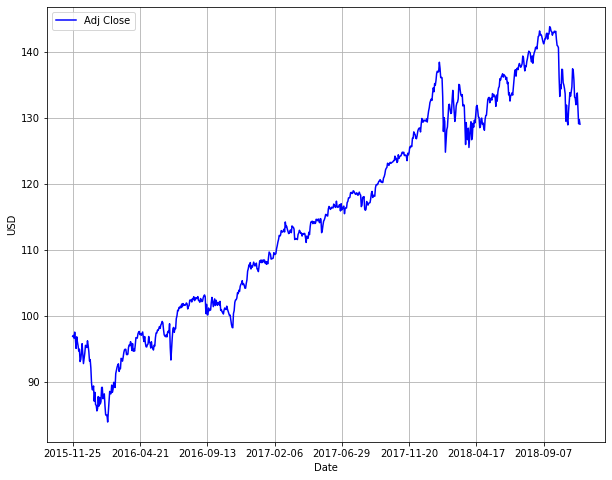

In [7]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='Date', y='Adj Close', style='b-', grid=True)
ax.set_xlabel("Date")
ax.set_ylabel("USD")

# Split data into Train and Test

In [8]:
# Date column is not needed. 
adj_close = pd.read_csv(data_path, usecols=[6], engine='python')
dataset = adj_close.values # converts to numpy array for easier transformations
dataset = dataset.astype('float32') # keras LSTM works better with floats

# Standardize data
scaler = StandardScaler()
dataset = scaler.fit_transform(dataset)
# Get sizes of each of the datasets
num_test = int(len(df)*test_size) # 20% of the data
num_train = len(df) - num_test

print("num_train = " + str(num_train))
print("num_test = " + str(num_test))

# Split into train and test data
train = dataset[0:num_train,:]
test = dataset[num_train:,:]

print("train.shape = " + str(train.shape))
print("test.shape = " + str(test.shape))

num_train = 604
num_test = 151
train.shape = (604, 1)
test.shape = (151, 1)


# Rescaling data and creating X and Y from the input data

In [9]:
# Converting dataset into x_train and y_train
# Only training dataset is scaled, and not the entire dataset to prevent information leak
#scaler = StandardScaler() # calculates (x-u)/s for each element

# Scaling Train data
# train = scaler.fit_transform(train) #reshape(-1,1) because we only have one feature

# Split into X samples and Y features
x_train, y_train = create_dataset(train, N, N)
print(x_train.shape)

# Reshape for LSTM input format: [samples, time-steps, features]
# x_train = np.reshape(x_train,(x_train.shape[0], 1 , x_train.shape[1]))
x_train = np.reshape(x_train,(x_train.shape[0], N , 1))
print("x_train.shape = " + str(x_train.shape)) # (446, 7, 1)
print("y_train.shape = " + str(y_train.shape)) # (446, 1)

(594, 9, 1)
x_train.shape = (594, 9, 1)
y_train.shape = (594, 1)


In [10]:
 # Scaling Test data
#test = scaler.fit_transform(test) #reshape(-1,1) because we only have one feature

# Split into X samples and Y features
x_test, y_test = create_dataset(test, N, N)

# Reshape for LSTM input format: [samples, time-steps, features]
# x_test = np.reshape(x_test,(x_test.shape[0], 1 , x_test.shape[1]))
x_test = np.reshape(x_test,(x_test.shape[0], N , 1))
print("x_test.shape = " + str(x_test.shape)) # (446, 7, 1)
print("y_test.shape = " + str(y_test.shape)) # (446, 1)

x_test.shape = (141, 9, 1)
y_test.shape = (141, 1)


# Configure and train the LSTM Network

In [11]:
# Original 
# Create the LSTM network

model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(N,1)))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

594/594 - 1s - loss: 0.0925


# Model Summary

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 9, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 9, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


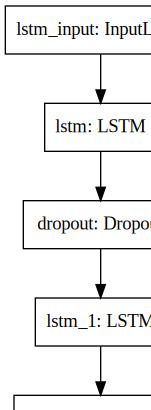

In [10]:
# Plot and save model
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='model_v4a.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Do prediction

In [11]:
# Do prediction
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
# est = inverse transform
#print("est.shape = " + str(est.shape))

# invert standardize data
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
# Calculate RMSE
trainScore = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
print('RMSE = %.2f RMSE' % (trainScore))

# Calculate MAPE
mape = mean_absolute_percentage_error(y_train[0], train_predict[:,0])*100
print("MAPE = %0.3f%%" % mape)

RMSE = 2.07 RMSE
MAPE = 1.465%


# Plot basline and predictions

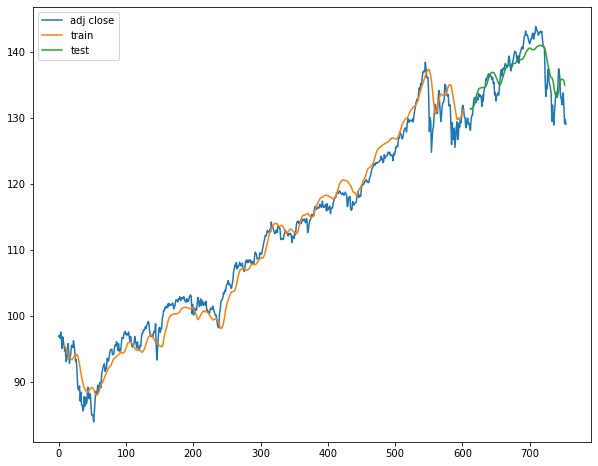

In [12]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
# shift train data for plotting
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:,:] = np.nan
train_predict_plot[N:len(train_predict)+N,:] = train_predict

# shift test data for plotting
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:,:] = np.nan
test_predict_plot[len(train_predict)+(N*2):len(dataset)-2, :] = test_predict


plt.plot(scaler.inverse_transform(dataset))
plt.plot(train_predict_plot, label='lofasz')
plt.plot(test_predict_plot)
plt.legend(['adj close','train', 'test'])
plt.show()

# Hyperparam tuning for N

In [13]:
param_label = 'N'
param_list = range(3, 60)

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    # Split train into x and y
    x_train, y_train = create_dataset(train, param, param)
    
    # Reshape data
    x_train = np.reshape(x_train,(x_train.shape[0], param , 1))
    
    # Train, predict and eval model
    #rmse, mape = train_pred_eval_model(x_train, \
    #                                      y_train, \
     #                                     scaler, \
      #                                    lstm_units=lstm_units, \
       #                                   dropout_prob=dropout_prob, \
        #                                  optimizer=optimizer, \
         #                                 epochs=epochs, \
          #                                batch_size=batch_size)
    
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(param,1)))
    model.add(Dropout(dropout_prob))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob))
    model.add(Dense(1))
    #
    ## compile model
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    ## train model
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
    
    # predict
    # Do prediction
    train_predict = model.predict(x_train)
    # est = inverse transform
    #print("est.shape = " + str(est.shape))

    # invert standardize data
    train_predict = scaler.inverse_transform(train_predict)
    y_train = scaler.inverse_transform([y_train])
    
    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
    # print('RMSE = %.2f RMSE' % (trainScore))

    #from sklearn.metrics import mean_absolute_percentage_error
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_train[0], train_predict[:,0])*100
    # print("MAPE = %0.3f%%" % mape)
    
    # Collect results
    
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

<ipython-input-13-3ad31b3c9dcb>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/57 [00:00<?, ?it/s]

600/600 - 1s - loss: 0.1081
599/599 - 1s - loss: 0.1025
598/598 - 2s - loss: 0.0796
597/597 - 2s - loss: 0.0891
596/596 - 2s - loss: 0.0951
595/595 - 1s - loss: 0.0840
594/594 - 2s - loss: 0.0898
593/593 - 2s - loss: 0.0893
592/592 - 2s - loss: 0.0777
591/591 - 2s - loss: 0.1108
590/590 - 2s - loss: 0.1003
589/589 - 2s - loss: 0.0984
588/588 - 2s - loss: 0.1053
587/587 - 2s - loss: 0.0846
586/586 - 2s - loss: 0.0995
585/585 - 2s - loss: 0.0787
584/584 - 3s - loss: 0.0895
583/583 - 3s - loss: 0.0956
582/582 - 3s - loss: 0.0929
581/581 - 3s - loss: 0.0862
580/580 - 3s - loss: 0.0885
579/579 - 3s - loss: 0.0951
578/578 - 3s - loss: 0.0839
577/577 - 3s - loss: 0.0850
576/576 - 3s - loss: 0.0879
575/575 - 3s - loss: 0.0974
574/574 - 4s - loss: 0.1011
573/573 - 4s - loss: 0.1044
572/572 - 4s - loss: 0.0987
571/571 - 4s - loss: 0.0860
570/570 - 4s - loss: 0.0797
569/569 - 4s - loss: 0.0959
568/568 - 4s - loss: 0.0762
567/567 - 4s - loss: 0.0799
566/566 - 4s - loss: 0.0867
565/565 - 4s - loss:

N      rmse  mape_pct
0    3  1.341027  0.861093
1    4  1.857357  1.296970
2    5  1.607714  1.108060
3    6  2.282039  1.544616
4    7  1.840765  1.354649
5    8  3.008974  2.193162
6    9  1.821385  1.245459
7   10  1.897484  1.374095
8   11  2.659520  1.774172
9   12  2.135601  1.402675
10  13  2.478734  1.590320
11  14  1.944742  1.340975
12  15  1.964235  1.259658
13  16  2.677692  1.892496
14  17  3.226070  2.435781
15  18  1.903796  1.242181
16  19  2.265832  1.442405
17  20  4.989317  3.764931
18  21  2.449085  1.512888
19  22  2.485652  1.812329
20  23  1.998759  1.300925
21  24  2.774701  1.985911
22  25  2.852739  2.106333
23  26  3.436792  2.728510
24  27  3.807242  2.843507
25  28  3.165621  2.296465
26  29  2.161323  1.480933
27  30  2.166734  1.391981
28  31  2.100986  1.312731
29  32  2.742977  1.880343
30  33  2.314174  1.611241
31  34  2.446047  1.688757
32  35  2.881236  2.084117
33  36  2.598403  1.850284
34  37  1.736159  1.096728
35  38  3.990856  3.109747
36  39  3.180785  2.286750
37  40  1.873599  1.264608
38  41  2.164115  1.445148
39  42  1.665911  1.100392
40  43  2.712289  1.991680
41  44  1.916377  1.293469
42  45  2.407313  1.786834
43  46  1.670831  1.071849
44  47  2.376517  1.755039
45  48  1.839480  1.204774
46  49  1.851882  1.177406
47  50  2.041961  1.467783
48  51  2.819684  1.832996
49  52  1.602997  1.067738
50  53  2.642123  1.900124
51  54  2.613186  1.874947
52  55  2.221783  1.605839
53  56  3.541094  2.588251
54  57  2.498305  1.790868
55  58  1.926677  1.303236
56  59  2.355359  1.704727

Text(0, 0.5, 'RMSE/MAPE(%)')

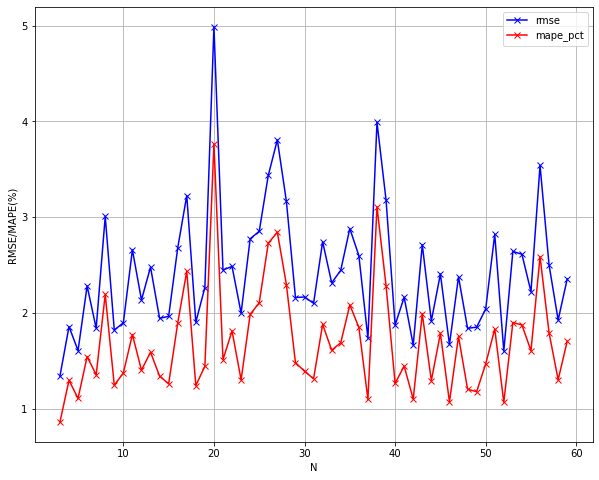

In [14]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

In [15]:
# Get optimum value for param
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(N_opt))


min RMSE = 1.341
min MAPE = 0.861%
optimum N = 3


# Hyperparameter tuning for epochs and batch_size

In [16]:
param_label = 'epochs'
param_list = [1, 10, 20, 30, 40, 50]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128]

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()

# Split train into x and y
x_train, y_train = create_dataset(train, N_opt, N_opt)
    
# Reshape data
x_train = np.reshape(x_train,(x_train.shape[0], N_opt , 1))

for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
        
        # Train, predict and eval model
        model = Sequential()
        model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(N_opt,1)))
        model.add(Dropout(dropout_prob))
        model.add(LSTM(units=lstm_units))
        model.add(Dropout(dropout_prob))
        model.add(Dense(1))
        #
        ## compile model
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        ## train model
        model.fit(x_train, y_train, epochs=param, batch_size=param2, verbose=2)
    
        # predict
        # Do prediction
        train_predict = model.predict(x_train)
        # est = inverse transform
        #print("est.shape = " + str(est.shape))

        # invert standardize data
        train_predict = scaler.inverse_transform(train_predict)
        y_train_orig = scaler.inverse_transform([y_train])
    
        # Calculate RMSE
        rmse = math.sqrt(mean_squared_error(y_train_orig[0], train_predict[:,0]))
        # print('RMSE = %.2f RMSE' % (trainScore))

        #from sklearn.metrics import mean_absolute_percentage_error
        # Calculate MAPE
        mape = mean_absolute_percentage_error(y_train_orig[0], train_predict[:,0])*100
        # print("MAPE = %0.3f%%" % mape)
    
        # Collect results
    
       # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

<ipython-input-16-6a67c570eb8f>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/6 [00:00<?, ?it/s]

<ipython-input-16-6a67c570eb8f>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param2 in tqdm_notebook(param2_list):


  0%|          | 0/5 [00:00<?, ?it/s]

75/75 - 0s - loss: 0.3246
38/38 - 0s - loss: 0.3866
19/19 - 0s - loss: 0.6333
10/10 - 0s - loss: 0.6789
5/5 - 0s - loss: 0.7478


<ipython-input-16-6a67c570eb8f>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param2 in tqdm_notebook(param2_list):


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/10
75/75 - 0s - loss: 0.2936
Epoch 2/10
75/75 - 0s - loss: 0.0467
Epoch 3/10
75/75 - 0s - loss: 0.0528
Epoch 4/10
75/75 - 0s - loss: 0.0425
Epoch 5/10
75/75 - 0s - loss: 0.0500
Epoch 6/10
75/75 - 0s - loss: 0.0353
Epoch 7/10
75/75 - 0s - loss: 0.0396
Epoch 8/10
75/75 - 0s - loss: 0.0381
Epoch 9/10
75/75 - 0s - loss: 0.0375
Epoch 10/10
75/75 - 0s - loss: 0.0385
Epoch 1/10
38/38 - 0s - loss: 0.4190
Epoch 2/10
38/38 - 0s - loss: 0.0715
Epoch 3/10
38/38 - 0s - loss: 0.0494
Epoch 4/10
38/38 - 0s - loss: 0.0472
Epoch 5/10
38/38 - 0s - loss: 0.0412
Epoch 6/10
38/38 - 0s - loss: 0.0417
Epoch 7/10
38/38 - 0s - loss: 0.0424
Epoch 8/10
38/38 - 0s - loss: 0.0355
Epoch 9/10
38/38 - 0s - loss: 0.0413
Epoch 10/10
38/38 - 0s - loss: 0.0374
Epoch 1/10
19/19 - 0s - loss: 0.6028
Epoch 2/10
19/19 - 0s - loss: 0.2193
Epoch 3/10
19/19 - 0s - loss: 0.0784
Epoch 4/10
19/19 - 0s - loss: 0.0560
Epoch 5/10
19/19 - 0s - loss: 0.0554
Epoch 6/10
19/19 - 0s - loss: 0.0475
Epoch 7/10
19/19 - 0s - loss: 0.0438

<ipython-input-16-6a67c570eb8f>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param2 in tqdm_notebook(param2_list):


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/20
75/75 - 0s - loss: 0.2740
Epoch 2/20
75/75 - 0s - loss: 0.0406
Epoch 3/20
75/75 - 0s - loss: 0.0612
Epoch 4/20
75/75 - 0s - loss: 0.0409
Epoch 5/20
75/75 - 0s - loss: 0.0489
Epoch 6/20
75/75 - 0s - loss: 0.0372
Epoch 7/20
75/75 - 0s - loss: 0.0391
Epoch 8/20
75/75 - 0s - loss: 0.0356
Epoch 9/20
75/75 - 0s - loss: 0.0403
Epoch 10/20
75/75 - 0s - loss: 0.0398
Epoch 11/20
75/75 - 0s - loss: 0.0360
Epoch 12/20
75/75 - 0s - loss: 0.0328
Epoch 13/20
75/75 - 0s - loss: 0.0395
Epoch 14/20
75/75 - 0s - loss: 0.0406
Epoch 15/20
75/75 - 0s - loss: 0.0318
Epoch 16/20
75/75 - 0s - loss: 0.0376
Epoch 17/20
75/75 - 0s - loss: 0.0336
Epoch 18/20
75/75 - 0s - loss: 0.0344
Epoch 19/20
75/75 - 0s - loss: 0.0341
Epoch 20/20
75/75 - 0s - loss: 0.0319
Epoch 1/20
38/38 - 0s - loss: 0.4344
Epoch 2/20
38/38 - 0s - loss: 0.0687
Epoch 3/20
38/38 - 0s - loss: 0.0496
Epoch 4/20
38/38 - 0s - loss: 0.0448
Epoch 5/20
38/38 - 0s - loss: 0.0474
Epoch 6/20
38/38 - 0s - loss: 0.0451
Epoch 7/20
38/38 - 0s - los

<ipython-input-16-6a67c570eb8f>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param2 in tqdm_notebook(param2_list):


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/30
75/75 - 0s - loss: 0.2684
Epoch 2/30
75/75 - 0s - loss: 0.0467
Epoch 3/30
75/75 - 0s - loss: 0.0574
Epoch 4/30
75/75 - 0s - loss: 0.0423
Epoch 5/30
75/75 - 0s - loss: 0.0497
Epoch 6/30
75/75 - 0s - loss: 0.0371
Epoch 7/30
75/75 - 0s - loss: 0.0383
Epoch 8/30
75/75 - 0s - loss: 0.0340
Epoch 9/30
75/75 - 0s - loss: 0.0394
Epoch 10/30
75/75 - 0s - loss: 0.0387
Epoch 11/30
75/75 - 0s - loss: 0.0358
Epoch 12/30
75/75 - 0s - loss: 0.0342
Epoch 13/30
75/75 - 0s - loss: 0.0374
Epoch 14/30
75/75 - 0s - loss: 0.0399
Epoch 15/30
75/75 - 0s - loss: 0.0330
Epoch 16/30
75/75 - 0s - loss: 0.0367
Epoch 17/30
75/75 - 0s - loss: 0.0341
Epoch 18/30
75/75 - 0s - loss: 0.0335
Epoch 19/30
75/75 - 0s - loss: 0.0344
Epoch 20/30
75/75 - 0s - loss: 0.0316
Epoch 21/30
75/75 - 0s - loss: 0.0349
Epoch 22/30
75/75 - 0s - loss: 0.0344
Epoch 23/30
75/75 - 0s - loss: 0.0342
Epoch 24/30
75/75 - 0s - loss: 0.0355
Epoch 25/30
75/75 - 0s - loss: 0.0343
Epoch 26/30
75/75 - 0s - loss: 0.0341
Epoch 27/30
75/75 - 0

<ipython-input-16-6a67c570eb8f>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param2 in tqdm_notebook(param2_list):


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/40
75/75 - 0s - loss: 0.3136
Epoch 2/40
75/75 - 0s - loss: 0.0476
Epoch 3/40
75/75 - 0s - loss: 0.0531
Epoch 4/40
75/75 - 0s - loss: 0.0459
Epoch 5/40
75/75 - 0s - loss: 0.0466
Epoch 6/40
75/75 - 0s - loss: 0.0373
Epoch 7/40
75/75 - 0s - loss: 0.0392
Epoch 8/40
75/75 - 0s - loss: 0.0379
Epoch 9/40
75/75 - 0s - loss: 0.0386
Epoch 10/40
75/75 - 0s - loss: 0.0379
Epoch 11/40
75/75 - 0s - loss: 0.0368
Epoch 12/40
75/75 - 0s - loss: 0.0325
Epoch 13/40
75/75 - 0s - loss: 0.0383
Epoch 14/40
75/75 - 0s - loss: 0.0395
Epoch 15/40
75/75 - 0s - loss: 0.0326
Epoch 16/40
75/75 - 0s - loss: 0.0368
Epoch 17/40
75/75 - 0s - loss: 0.0342
Epoch 18/40
75/75 - 0s - loss: 0.0348
Epoch 19/40
75/75 - 0s - loss: 0.0330
Epoch 20/40
75/75 - 0s - loss: 0.0317
Epoch 21/40
75/75 - 0s - loss: 0.0332
Epoch 22/40
75/75 - 0s - loss: 0.0352
Epoch 23/40
75/75 - 0s - loss: 0.0337
Epoch 24/40
75/75 - 0s - loss: 0.0357
Epoch 25/40
75/75 - 0s - loss: 0.0344
Epoch 26/40
75/75 - 0s - loss: 0.0340
Epoch 27/40
75/75 - 0

<ipython-input-16-6a67c570eb8f>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param2 in tqdm_notebook(param2_list):


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/50
75/75 - 0s - loss: 0.3021
Epoch 2/50
75/75 - 0s - loss: 0.0493
Epoch 3/50
75/75 - 0s - loss: 0.0534
Epoch 4/50
75/75 - 0s - loss: 0.0409
Epoch 5/50
75/75 - 0s - loss: 0.0455
Epoch 6/50
75/75 - 0s - loss: 0.0353
Epoch 7/50
75/75 - 0s - loss: 0.0393
Epoch 8/50
75/75 - 0s - loss: 0.0351
Epoch 9/50
75/75 - 0s - loss: 0.0379
Epoch 10/50
75/75 - 0s - loss: 0.0400
Epoch 11/50
75/75 - 0s - loss: 0.0356
Epoch 12/50
75/75 - 0s - loss: 0.0326
Epoch 13/50
75/75 - 0s - loss: 0.0381
Epoch 14/50
75/75 - 0s - loss: 0.0384
Epoch 15/50
75/75 - 0s - loss: 0.0318
Epoch 16/50
75/75 - 0s - loss: 0.0373
Epoch 17/50
75/75 - 0s - loss: 0.0344
Epoch 18/50
75/75 - 0s - loss: 0.0342
Epoch 19/50
75/75 - 0s - loss: 0.0342
Epoch 20/50
75/75 - 0s - loss: 0.0313
Epoch 21/50
75/75 - 0s - loss: 0.0351
Epoch 22/50
75/75 - 0s - loss: 0.0348
Epoch 23/50
75/75 - 0s - loss: 0.0342
Epoch 24/50
75/75 - 0s - loss: 0.0366
Epoch 25/50
75/75 - 0s - loss: 0.0350
Epoch 26/50
75/75 - 0s - loss: 0.0350
Epoch 27/50
75/75 - 0

Epoch 19/50
5/5 - 0s - loss: 0.0483
Epoch 20/50
5/5 - 0s - loss: 0.0442
Epoch 21/50
5/5 - 0s - loss: 0.0443
Epoch 22/50
5/5 - 0s - loss: 0.0412
Epoch 23/50
5/5 - 0s - loss: 0.0507
Epoch 24/50
5/5 - 0s - loss: 0.0448
Epoch 25/50
5/5 - 0s - loss: 0.0396
Epoch 26/50
5/5 - 0s - loss: 0.0398
Epoch 27/50
5/5 - 0s - loss: 0.0483
Epoch 28/50
5/5 - 0s - loss: 0.0435
Epoch 29/50
5/5 - 0s - loss: 0.0404
Epoch 30/50
5/5 - 0s - loss: 0.0461
Epoch 31/50
5/5 - 0s - loss: 0.0396
Epoch 32/50
5/5 - 0s - loss: 0.0436
Epoch 33/50
5/5 - 0s - loss: 0.0428
Epoch 34/50
5/5 - 0s - loss: 0.0456
Epoch 35/50
5/5 - 0s - loss: 0.0426
Epoch 36/50
5/5 - 0s - loss: 0.0464
Epoch 37/50
5/5 - 0s - loss: 0.0382
Epoch 38/50
5/5 - 0s - loss: 0.0439
Epoch 39/50
5/5 - 0s - loss: 0.0423
Epoch 40/50
5/5 - 0s - loss: 0.0419
Epoch 41/50
5/5 - 0s - loss: 0.0478
Epoch 42/50
5/5 - 0s - loss: 0.0412
Epoch 43/50
5/5 - 0s - loss: 0.0364
Epoch 44/50
5/5 - 0s - loss: 0.0405
Epoch 45/50
5/5 - 0s - loss: 0.0393
Epoch 46/50
5/5 - 0s - loss:

epochs  batch_size       rmse   mape_pct
0        1           8   1.798758   1.282536
1        1          16   3.908871   2.734388
2        1          32  10.174613   8.127529
3        1          64  11.593035   9.336561
4        1         128  13.150722  10.635305
5       10           8   1.238342   0.855203
6       10          16   1.275059   0.831113
7       10          32   1.384964   0.895086
8       10          64   1.444566   0.913005
9       10         128   2.852456   1.627521
10      20           8   1.166353   0.785682
11      20          16   1.323948   0.911694
12      20          32   1.281473   0.848429
13      20          64   1.321433   0.855687
14      20         128   1.249152   0.798268
15      30           8   1.210635   0.819519
16      30          16   1.442205   0.962394
17      30          32   1.341441   0.863834
18      30          64   1.263834   0.860179
19      30         128   1.328975   0.849537
20      40           8   1.437477   0.954457
21      40          16   1.369866   0.919849
22      40          32   1.421807   1.033455
23      40          64   1.368953   0.911024
24      40         128   1.382036   0.906368
25      50           8   1.412130   0.906562
26      50          16   1.171482   0.802210
27      50          32   1.194629   0.802582
28      50          64   1.302878   0.836997
29      50         128   1.250187   0.810023

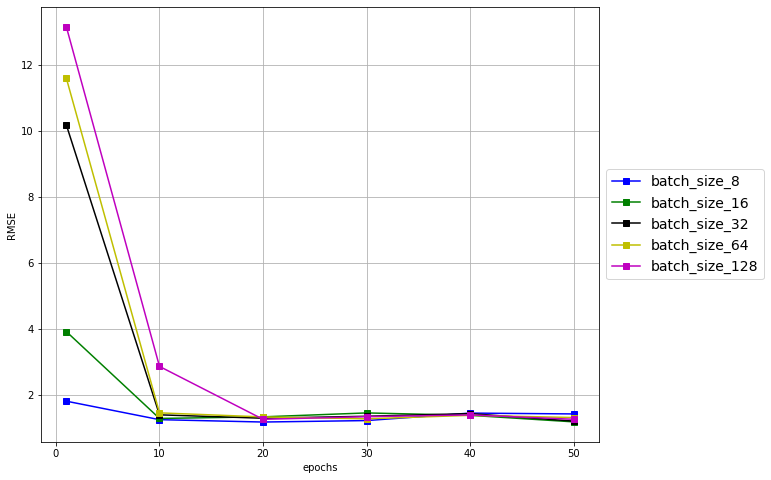

In [17]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
# ax.set_xlim([10, 50])
# ax.set_ylim([0, 5])

In [18]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

min RMSE = 1.166
min MAPE = 0.786%
optimum epochs = 20
optimum batch_size = 8


# Final model

In [19]:
# Split train_cv into x and y
x_train, y_train = create_dataset(train, N_opt, N_opt)
x_train = np.reshape(x_train,(x_train.shape[0], N_opt , 1))

# Split test into x and y
x_test, y_test = create_dataset(test, N_opt, N_opt)
x_test = np.reshape(x_test,(x_test.shape[0], N_opt , 1))

model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(N_opt,1)))
model.add(Dropout(dropout_prob))
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob))
model.add(Dense(1))
#
## compile model
model.compile(loss='mean_squared_error', optimizer=optimizer)
## train model
model.fit(x_train, y_train, epochs=epochs_opt, batch_size=batch_size_opt, verbose=2)
    
# save model
model.save('optimal_lstm.h5')
# predict
# Do prediction
train_predict = model.predict(x_train)
# est = inverse transform
#print("est.shape = " + str(est.shape))

# invert standardize data
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
    
# Calculate RMSE
rmse = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
# print('RMSE = %.2f RMSE' % (trainScore))

#from sklearn.metrics import mean_absolute_percentage_error
# Calculate MAPE
mape = mean_absolute_percentage_error(y_train[0], train_predict[:,0])*100

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

Epoch 1/20
75/75 - 0s - loss: 0.3007
Epoch 2/20
75/75 - 0s - loss: 0.0448
Epoch 3/20
75/75 - 0s - loss: 0.0539
Epoch 4/20
75/75 - 0s - loss: 0.0431
Epoch 5/20
75/75 - 0s - loss: 0.0499
Epoch 6/20
75/75 - 0s - loss: 0.0364
Epoch 7/20
75/75 - 0s - loss: 0.0391
Epoch 8/20
75/75 - 0s - loss: 0.0353
Epoch 9/20
75/75 - 0s - loss: 0.0392
Epoch 10/20
75/75 - 0s - loss: 0.0398
Epoch 11/20
75/75 - 0s - loss: 0.0376
Epoch 12/20
75/75 - 0s - loss: 0.0334
Epoch 13/20
75/75 - 0s - loss: 0.0375
Epoch 14/20
75/75 - 0s - loss: 0.0405
Epoch 15/20
75/75 - 0s - loss: 0.0327
Epoch 16/20
75/75 - 0s - loss: 0.0367
Epoch 17/20
75/75 - 0s - loss: 0.0349
Epoch 18/20
75/75 - 0s - loss: 0.0341
Epoch 19/20
75/75 - 0s - loss: 0.0341
Epoch 20/20
75/75 - 0s - loss: 0.0309
RMSE on test set = 1.186
MAPE on test set = 0.778%


# Predict with final model

In [21]:
# Date column is not needed. 
adj_close = pd.read_csv(data_path, usecols=[6], engine='python')
dataset = adj_close.values # converts to numpy array for easier transformations
dataset = dataset.astype('float32') # keras LSTM works better with floats

# Standardize data
scaler = StandardScaler()
dataset = scaler.fit_transform(dataset)

# Get sizes of each of the datasets
num_test = int(len(df)*test_size) # 20% of the data
num_train = len(df) - num_test

# Split into train and test data
train = dataset[0:num_train,:]
test = dataset[num_train:,:]

# Converting dataset into x_train and y_train
# Only training dataset is scaled, and not the entire dataset to prevent information leak
#scaler = StandardScaler() # calculates (x-u)/s for each element

# Scaling Train data
# train = scaler.fit_transform(train) #reshape(-1,1) because we only have one feature

# Split into X samples and Y features
x_train, y_train = create_dataset(train, N_opt, N_opt)
print(x_train.shape)

# Reshape for LSTM input format: [samples, time-steps, features]
# x_train = np.reshape(x_train,(x_train.shape[0], 1 , x_train.shape[1]))
x_train = np.reshape(x_train,(x_train.shape[0], N_opt , 1))
print("x_train.shape = " + str(x_train.shape)) # (446, 7, 1)
print("y_train.shape = " + str(y_train.shape)) # (446, 1)

 # Scaling Test data
#test = scaler.fit_transform(test) #reshape(-1,1) because we only have one feature

# Split into X samples and Y features
x_test, y_test = create_dataset(test, N_opt, N_opt)

# Reshape for LSTM input format: [samples, time-steps, features]
# x_test = np.reshape(x_test,(x_test.shape[0], 1 , x_test.shape[1]))
x_test = np.reshape(x_test,(x_test.shape[0], N_opt , 1))
print("x_test.shape = " + str(x_test.shape)) # (446, 7, 1)
print("y_test.shape = " + str(y_test.shape)) # (446, 1)

# Do prediction
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
# est = inverse transform
#print("est.shape = " + str(est.shape))

# invert standardize data
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
# Calculate RMSE
trainScore = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
print('RMSE = %.2f RMSE' % (trainScore))

# Calculate MAPE
mape = mean_absolute_percentage_error(y_train[0], train_predict[:,0])*100
print("MAPE = %0.3f%%" % mape)

(600, 3, 1)
x_train.shape = (600, 3, 1)
y_train.shape = (600, 1)
x_test.shape = (147, 3, 1)
y_test.shape = (147, 1)
RMSE = 1.19 RMSE
MAPE = 0.778%


# Plot optimized model

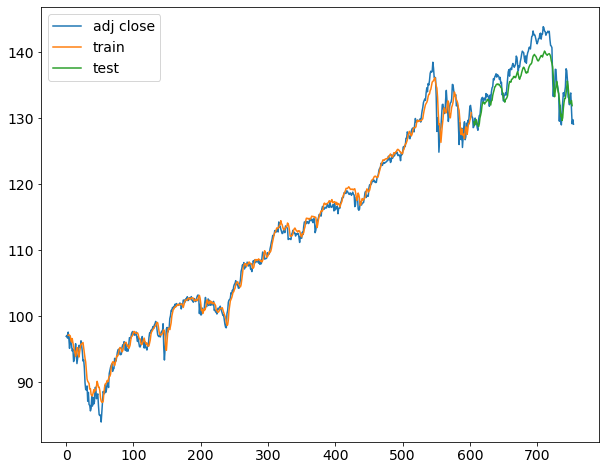

In [23]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
# shift train data for plotting
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:,:] = np.nan
train_predict_plot[N_opt:len(train_predict)+N_opt,:] = train_predict

# shift test data for plotting
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:,:] = np.nan
test_predict_plot[len(train_predict)+(N_opt*2):len(dataset)-2, :] = test_predict


plt.plot(scaler.inverse_transform(dataset))
plt.plot(train_predict_plot, label='lofasz')
plt.plot(test_predict_plot)
plt.legend(['adj close','train', 'test'])
plt.show()